In [21]:
import numpy as np

Lectura de archivos de audio:

In [9]:
import librosa as lb
from IPython.display import Audio

#%% Lectura de archivos de audio 
samples, sampling_rate= lb.load("../Data/Train/ADS_train_audio_22kHz.wav", sr=None, mono=True,offset=0.0,duration=None)
# Duración en segundos:
duration = len(samples)/sampling_rate
# Escuchar el audio:
Audio("../Data/Train/ADS_train_audio_22kHz.wav")

# Cargar respuesta al impulso:
ir_samples, ir_sampling_rate= lb.load("../Data/Train/ir_golpe22_short.wav", sr=None, mono=True,offset=0.0,duration=None)
ir_duration = len(ir_samples)/ir_sampling_rate

ts_samples, ts_sampling_rate = lb.load("../Data/Train/QueenWatch1.wav", sr=22050, mono=True,offset=0.0,duration=None)
ts_duration = len(ts_samples)/ts_sampling_rate



### Plot audio signals:

In [16]:
import matplotlib.pyplot as plt
import librosa.display

### Original Speech Signal:

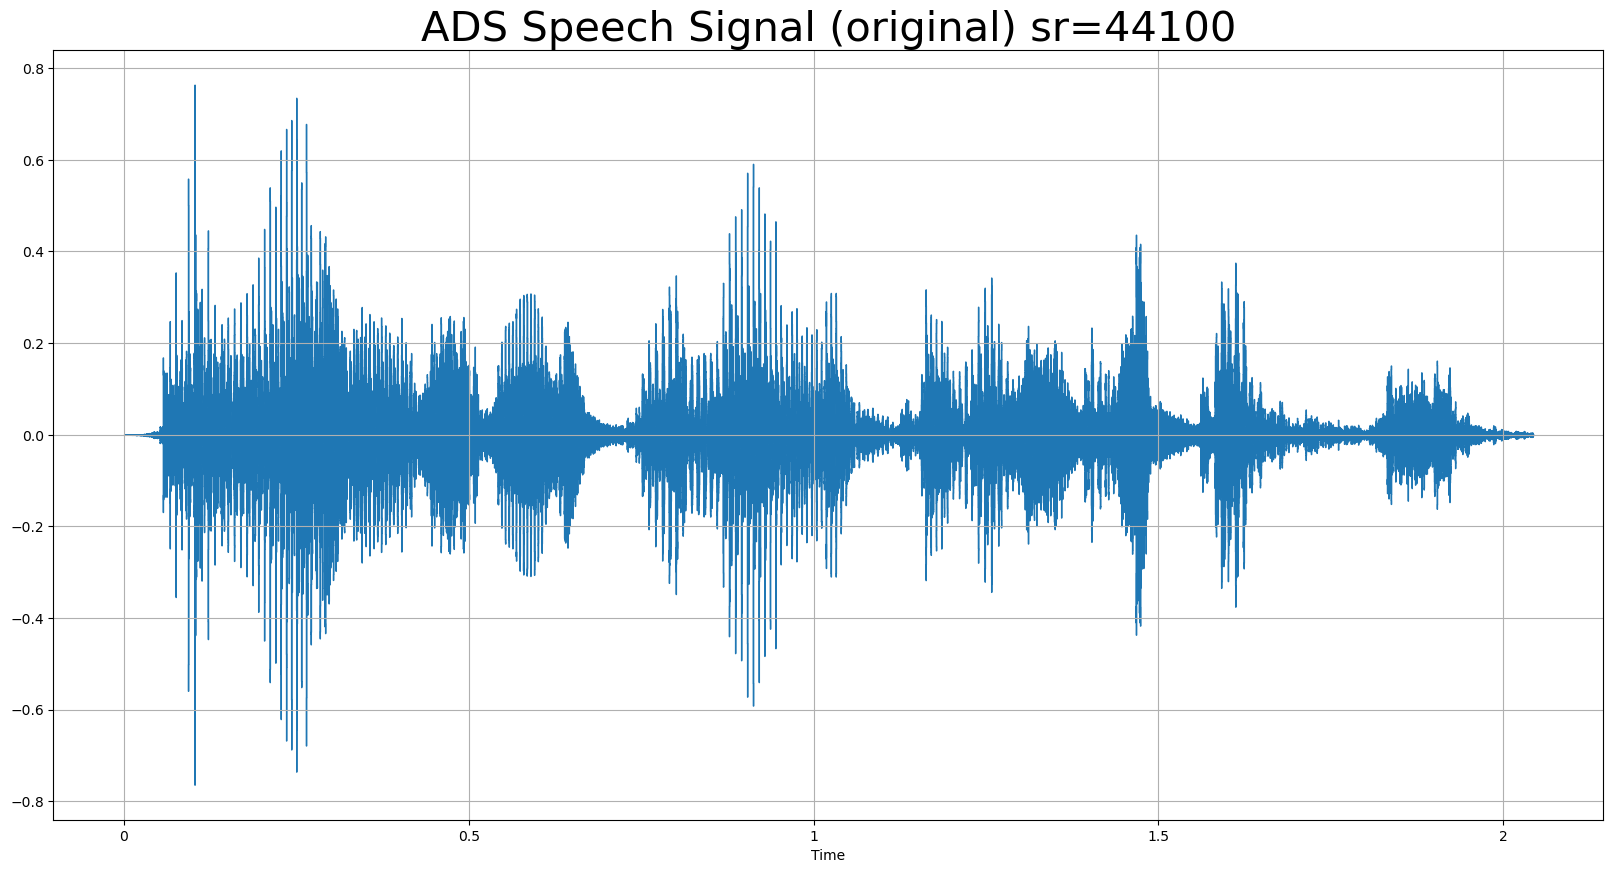

In [17]:
fig = plt.figure(figsize=(20,10))
plt.title(f'ADS Speech Signal (original) sr={sampling_rate}',fontsize=30)
plt.grid()
lb.display.waveshow(y=samples,sr=sampling_rate)
plt.show()
fig.savefig(f'../Figures/Original_signal_sr={sampling_rate}')


### Impulse Response Signal:

**Sampling rate:** 22.050 kHz

**Length:** seconds 

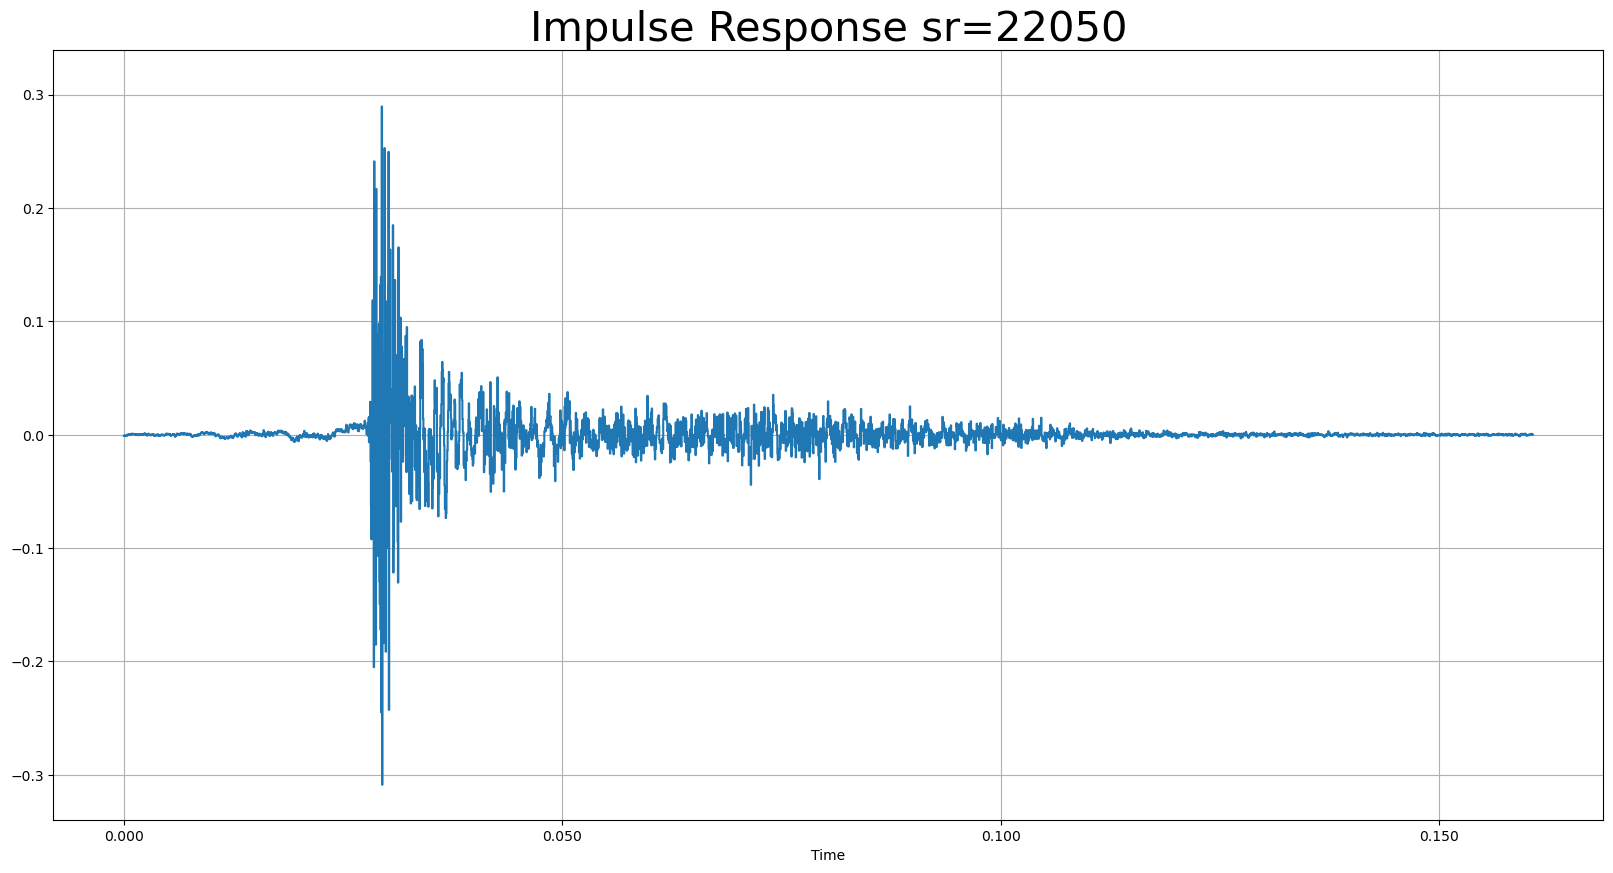

In [24]:
fig = plt.figure(figsize=(20,10))
plt.title(f'Impulse Response sr={ir_sampling_rate}', fontsize=30)
plt.grid()
lb.display.waveshow(y=ir_samples,sr=ir_sampling_rate)
plt.show()
fig.savefig(f'../Figures/Impulse_Response_sr={ir_sampling_rate}')

### Convolution between train signals and impulse response

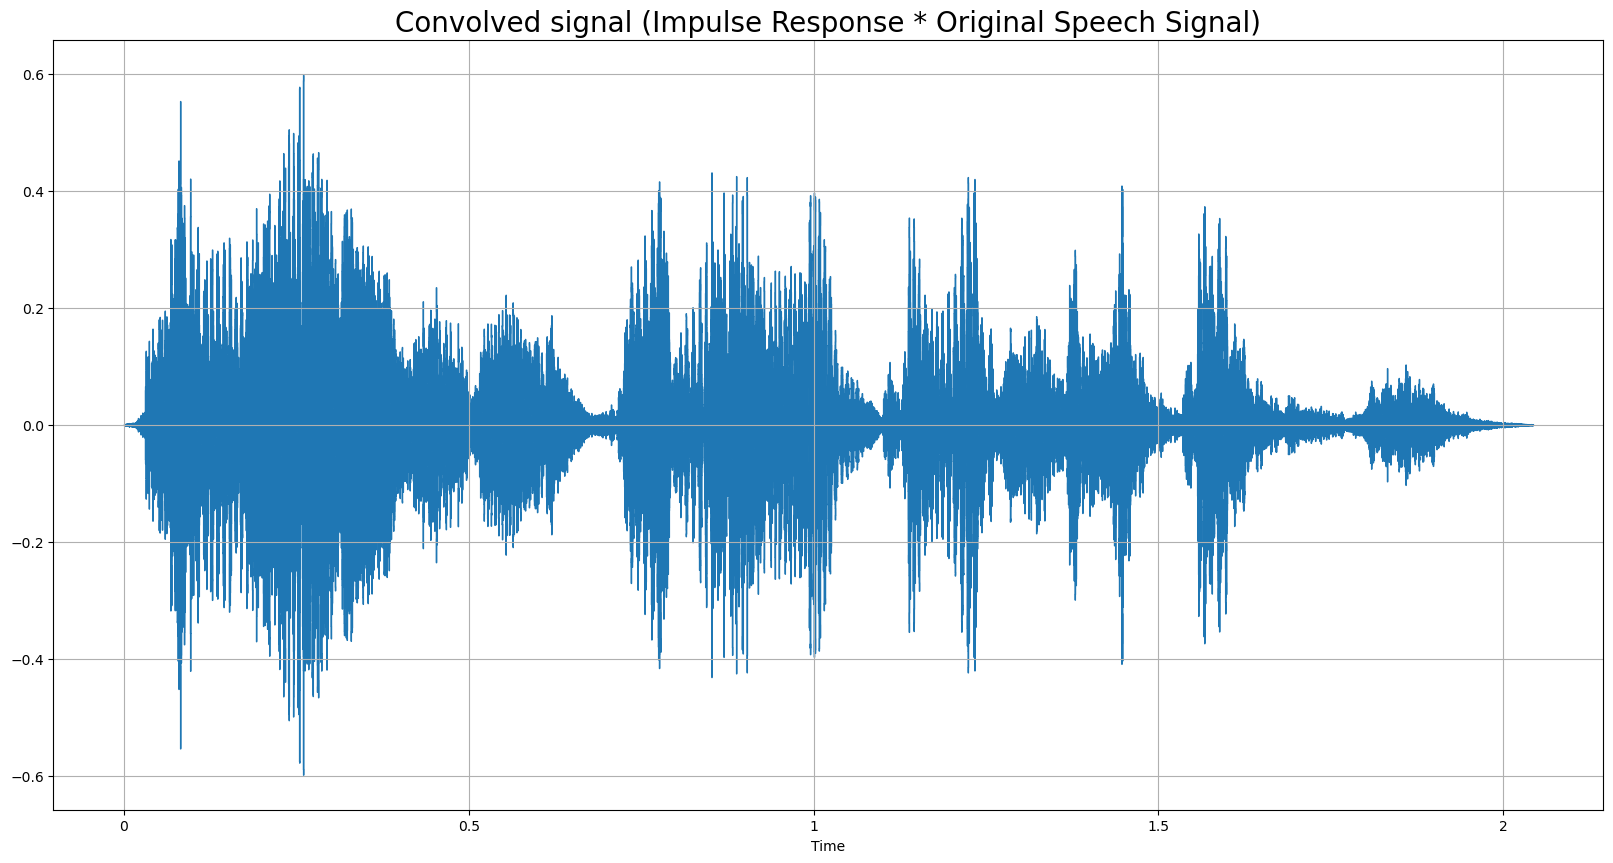

NameError: name 'sf' is not defined

In [29]:
# Convolución de numpy:
conv_signal = np.convolve(samples, ir_samples, mode='same')
# Plot the resulting singal:
fig = plt.figure(figsize=(20,10))
plt.title('Convolved signal (Impulse Response * Original Speech Signal)',fontsize=20)
plt.grid()
lb.display.waveshow(y=conv_signal,sr=sampling_rate)
plt.show()
fig.savefig(f'../Figures/Convolved_signal')
conv_signal.astype(np.int16).tofile('../Data/Train/conv_signal.wav')
sf.write('../Data/Train/convolved_signal.wav',conv_signal, sampling_rate, subtype=None)

---

Delayed Signal (Lags) Matrix generation

In [ ]:
n_lag = 5
n_lag_range = np.array([i for i in range(0,n_lag)])
dim_conv_signal = np.shape(conv_signal)
# Lag matrix of dimmensions: convolved signal - lag number (rows) x lag number (columns)
lag_matrix = np.zeros((dim_conv_signal[0]-n_lag, n_lag))
for i in range(n_lag):
        lag_matrix[:,i] = conv_signal[i : dim_conv_signal[0]-n_lag+i]
# del_sig = conv_signal[2:-1]
# del_sig2 = conv_signal[1:-2]
# del_sig3 = conv_signal[:-3]

# del_sig = conv_signal[:-7]
# del_sig2 = conv_signal[1:-6]
# del_sig3 = conv_signal[2:-5]
# del_sig4 = conv_signal[3:-4]
# del_sig5 = conv_signal[4:-3]
# del_sig6 = conv_signal[5:-2]
# del_sig7 = conv_signal[6:-1]
# matrix = np.c_[del_sig, del_sig2, del_sig3]
# matrix7 = np.c_[del_sig, del_sig2, del_sig3, del_sig4, del_sig5, del_sig6, del_sig7]

# Random plot one of the lagged signals:
r_int = np.random.randint(0,n_lag)
fig = plt.figure(figsize=(20,10))
plt.title(f'{r_int} lags sample of the Lagged Signals Matrix : ',fontsize=20)
plt.grid()
lb.display.waveplot(y=lag_matrix[r_int],sr=sampling_rate)
plt.show()

#%% Train dataset and Test dataset split
X_train = lag_matrix
Y_train = samples[n_lag:]

#%% Time-Delay Neural Network model

# Hyperparameters:
Epochs = 200
Learning_rate = 0.05
Decay_rate = Learning_rate/Epochs
Momentum = 0.8
Batch_size = 200

# Model definition:
model = Sequential()

nn_i, nn_h1, nn_h2 = 10,5,5
# Layer(s) definition:
model.add(Dense(nn_i, input_shape=(n_lag,), activation="tanh", name="input_layer_2"))
model.add(Dense(nn_h1, activation="tanh", name="hidden_layer_1"))
# model.add(Dense(nn_h2, activation="tanh", name="hidden_layer_2"))
# model.add(TDNNLayer([-5,2],True, input_shape=(45053,1), activation="tanh"))
model.add(Dense(1, activation='linear', name="output_layer"))

# Compile model:
model.compile(optimizer=Adam(learning_rate =Learning_rate), loss='MeanSquaredError', metrics=['mse'])
xtrain = lag_matrix
# xtrain = preprocessing.scale(xtrain)
ytrain = samples[n_lag:]

# Train model:
m_hist = model.fit(xtrain, ytrain, epochs=Epochs, batch_size=Batch_size, verbose=1)

#%% Plot the loss function and the metrics
fig, axs = plt.subplots(2, 1, figsize=(20,12))
fig.subplots_adjust(hspace=0.3)
axs[0].set_title(f'Loss: {n_lag} lags, Neurons: {nn_i}i, {nn_h1}h, {nn_h2}h2, Epochs:{Epochs}, Batch:{Batch_size}, LR:{Learning_rate}', fontsize=20, fontname="Times New Roman", fontweight='bold')
axs[0].plot(m_hist.history['loss'], 'r', label='train')
# ax.plot(m_hist.history['val_loss'], 'b' ,label='val')
axs[0].set_xlabel(r'Epoch', fontsize=20)
axs[0].set_ylabel(r'Loss', fontsize=20)
axs[0].grid(True)
axs[0].legend()
axs[0].tick_params(labelsize=20)

# Plot the Mean-Square Error
# fig, ax = plt.subplots(2, 2, figsize=(10,6))
# ax.plot(np.sqrt(m_hist.history['mean_squared_error']), 'r', label='train')
# ax.plot(np.sqrt(m_hist.history['val_mean_squared_error']), 'b' ,label='val')
axs[1].set_title(f'MSE: {n_lag} lags, Neurons: {nn_i}i, {nn_h1}h, {nn_h2}h2, Epochs:{Epochs}, Batch:{Batch_size}, LR:{Learning_rate}', fontsize=20, fontname="Times New Roman", fontweight='bold')
axs[1].plot(np.sqrt(m_hist.history['mse']), 'r', label='train')
# ax.plot(np.sqrt(m_hist.history['val_mse']), 'b' ,label='val')
axs[1].set_xlabel(r'Epoch', fontsize=20)
axs[1].set_ylabel(r'MSE', fontsize=20)
axs[1].grid(True)
axs[1].legend()
axs[1].tick_params(labelsize=20)
fig.savefig(f'../Figures/Loss_MSE_{n_lag}lags_{nn_i}i_{nn_h1}h1_{nn_h2}h2_{Epochs}e_{Batch_size}bs_{Learning_rate}lr.png')
#%% View model
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='../Figures/model.png', show_shapes = True)
#%% Prediction 

y_pred = model.predict(xtrain)

# Plotting original signal:
fig, axs = plt.subplots(2, 1, figsize=(30,12))
fig.subplots_adjust(hspace=0.4)
# plt.tight_layout(pad=0.7)
axs[0].set_title(f'Original Signal', fontsize=30, fontname="Times New Roman", fontweight='bold')
axs[0].plot(samples,c='b')
axs[0].set_xlabel('Samples', fontsize=30)
axs[0].set_ylabel('Amplitude', fontsize=30)
axs[0].grid(True)

# Plotting predicted signal (y hat):
# fig = plt.figure(figsize=(20,10))
axs[1].set_title(f'Y_hat: {n_lag} lags, Neurons: {nn_i}i, {nn_h1}h, {nn_h2}h2, Epochs:{Epochs}, Batch:{Batch_size}, LR:{Learning_rate}', fontsize=30, fontname="Times New Roman", fontweight='bold')
axs[1].plot(y_pred,c='g')
axs[1].set_xlabel('Samples', fontsize=30)
axs[1].set_ylabel('Amplitude', fontsize=30)
axs[1].grid(True)
plt.show()
fig.savefig(f'../Figures/y_hat_{n_lag}lags_{nn_i}i_{nn_h1}h_{nn_h2}h2_{Epochs}e_{Batch_size}bs_{Learning_rate}lr.png', dpi=450 )

# Save to sound file:
sf.write(f'../Data/predicted_signal_{n_lag}lags_{nn_i}i_{nn_h1}h1_{nn_h2}h2_{Epochs}e_{Batch_size}bs_{Learning_rate}lr.wav',y_pred, sampling_rate, subtype=None)
#%% Evaluate performance:
    
R2_score = r2_score(ytrain,y_pred)
# Plotting R2_Score
xmin,xmax = min(ytrain),max(ytrain)
xline = np.linspace(xmin,xmax)
fig = plt.figure(figsize=(20,15))
plt.scatter(ytrain,y_pred,label='Estimation')
plt.plot(xline,xline,'k--',label='Perfect estimation')
plt.xlabel('Real output', fontsize=35, fontname="Times New Roman",)
plt.ylabel('Estimation output', fontsize=35, fontname="Times New Roman",)
plt.suptitle('R^2=%0.4f'%R2_score, fontsize=40, fontname="Times New Roman", fontweight='bold')
plt.title(f'{n_lag}lags_{nn_i}i_{nn_h1}h1_{nn_h2}h2_{Epochs}e_{Batch_size}bs_{Learning_rate}lr', fontsize=30,fontname="Times New Roman" )
plt.legend()
plt.grid()
plt.show()
fig.savefig(f'../Figures/R2_{n_lag}lags_{nn_i}i_{nn_h1}h1_{nn_h2}h2_{Epochs}e_{Batch_size}bs_{Learning_rate}lr.png', dpi=450)

#%%  Test

# Queen_y_pred = model.predict(ts_samples)
# sf.write('../Data/queen_predicted_signal.wav',Queen_y_pred, ts_sampling_rate, subtype=None)
# plt.show()
# plt.figure()
# plt.title('Queen Predicted Signal')
# plt.plot(Queen_y_pred,c='r')

# score = model.evaluate(matrix, samples[3:])
# print('Test loss:', score[0])
# print('Test mse:', score[1])

# corr = sig.correlate(y_pred, y_pred)

# plt.figure()
# plt.title('Signals Correlation')
# plt.plot(corr)
# plt.show()

#%% Hyperparameter tunning
from sklearn.model_selection import GridSearchCV

# RandomSearchCV

#%% XGBoost Model Approach

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score


xgb_model = xgb.XGBRegressor()
# parameter definitions
param_grid = {
    'n_estimators': range(100, 200, 10), # De 50 hasta 250 estimadores en aumentos de 50
    'learning_rate': [0.05, 0.1, 0.3, 1], # Eta
    'max_depth': range(2, 5, 1),
    'subsample': [0.2, 0.5, 0.7, 1] # Submuestreo aleatorio para prevenir overfitting
}

grid_search = GridSearchCV(estimator=xgb_model, 
                  param_grid=param_grid,
                  #scoring='neg_mean_squared_error',
                  scoring='r2',
                  n_jobs=-1, # All procesors
                  cv=5,
                  verbose=4)

#grid_search.fit(X_train, Y_train)



print("Mejores parámetros:",grid_search.best_params_)

# Dictionary of best parameters:
best_params = {
    'n_estimators': 100, # De 50 hasta 250 estimadores en aumentos de 50
    'learning_rate': 0.1, # Eta
    'max_depth': 5,
    'subsample': 0.5
    }

# Create model with best params:
xgb_model_best_params = xgb.XGBRegressor(
                             n_estimators = best_params['n_estimators'],
                             max_depth = best_params['max_depth'],
                             eval_metric = 'r2',
                             learning_rate = best_params['learning_rate'],
                             verbosity = 4,
                             n_jobs = -1,
                             gamma = 1,)
#%%
xgb_best_model = grid_search.best_estimator_
# Save model for model persistence:
xgb_best_model.save_model("../Models/xgb_best_model.json")

# Realizar predicción sobre la señal original:
xgb_best_Yhat = xgb_best_model.predict(conv_signal)

# Calcular scores de la predicción del modelo:
xgb_best_rmse = (mean_squared_error(samples, xgb_best_Yhat)**0.5)
xgb_best_mae = mean_absolute_error(samples, xgb_best_Yhat)
xgb_best_mape = mean_absolute_percentage_error(samples, xgb_best_Yhat)
xgb_best_r2 = r2_score(samples, xgb_best_Yhat)
print('RMSE: {0:.3f}'.format(xgb_best_rmse))
print('MAE: {0:.3f}'.format(xgb_best_mae))
print('MAPE: {0:.3f}'.format(xgb_best_mape))
print('R^2: {0:.3f}'.format(xgb_best_r2))

# Graph and save the predicted signal:
xgb_best_Yhat = xgb_best_model.predict(conv_signal)

# Plotting original signal:
fig, axs = plt.subplots(2, 1, figsize=(30,12))
fig.subplots_adjust(hspace=0.4)
# plt.tight_layout(pad=0.7)
axs[0].set_title(f'Original Signal', fontsize=30, fontname="Times New Roman", fontweight='bold')
axs[0].plot(samples,c='b')
axs[0].set_xlabel('Samples', fontsize=30)
axs[0].set_ylabel('Amplitude', fontsize=30)
axs[0].grid(True)

# Plotting predicted signal (y hat):
# fig = plt.figure(figsize=(20,10))
axs[1].set_title(f'Y_hat: {n_lag} lags, Neurons: {nn_i}i, {nn_h1}h, {nn_h2}h2, Epochs:{Epochs}, Batch:{Batch_size}, LR:{Learning_rate}', fontsize=30, fontname="Times New Roman", fontweight='bold')
axs[1].plot(xgb_best_Yhat ,c='g')
axs[1].set_xlabel('Samples', fontsize=30)
axs[1].set_ylabel('Amplitude', fontsize=30)
axs[1].grid(True)
plt.show()
fig.savefig(f'../Figures/xgb_yhat_{n_lag}lags_{n_estimators}estimators_{max_depth}mdepth_{nn_h2}h2_{Epochs}e_{Batch_size}bs_{xgb_learning_rate}lr.png', dpi=450 )

# Save to sound file:
sf.write(f'../Data/Test/xgb_predicted_signal_{n_lag}lags_{nn_i}i_{nn_h1}h1_{nn_h2}h2_{Epochs}e_{Batch_size}bs_{Learning_rate}lr.wav',y_pred, sampling_rate, subtype=None)

#%% Save a model to JSON

# serialize model to JSON
model_json = model.to_json()

with open("../Figures/TDNN_model.json", "w") as json_file:
    json_file.write(model_json)

# save weights to HDF5
model.save_weights("../Figures/TDNN_model.h5")
print("Model saved")

#%% Retrieve the model: load json and create model
# from keras.models import model_from_json
# json_file = open('../Figures/TDNN_model.json', 'r')
# saved_model = json_file.read()
# close the file as good practice:
# json_file.close()
# model_ = model_from_json(saved_model)
# load weights into new model:
# model_.load_weights("../Figures/TDNN_model.h5")
# print("Model loaded")
